<a href="https://colab.research.google.com/github/yuuz1/Face-based-identity-recognition-CSCI218/blob/main/T05_FaceRec_3Pipelines_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition (AT&T / ORL) — **3 Pipelines** in Google Colab

**Pipeline A (Baseline):** PCA (“Eigenfaces-style”) + Linear SVM  
**Pipeline B (Winner):** Pretrained CNN embeddings (ResNet18, feature extractor only) + Linear SVM  
**Pipeline C (New):** **MLP (Multi-Layer Perceptron)** on flattened pixels (with standardization)

✅ Offline evaluation only (accuracy, macro P/R/F1, confusion matrix, runtime)  
✅ Same identity-stratified split for all pipelines (**7 train / 3 test per subject**)  




In [ ]:
# CELL 0 — Setup + Settings + Utilities

import os, sys, time, zipfile, shutil, math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

SEEDS = [42, 123, 256, 789, 1024]
N_TEST_PER_SUBJECT = 3
APPLY_HIST_EQ = True

RESULTS_DIR = Path("/content/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

PCA_COMPONENTS_GRID = [20, 40, 60, 80, 100, 120, 150]
SVM_C_GRID = [0.1, 1, 10, 100]

MLP_HIDDEN_GRID = [(256,), (512,), (256, 128)]
MLP_ALPHA_GRID = [1e-4, 1e-3, 1e-2]

EMB_BATCH_SIZE = 64

def eval_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return acc, p, r, f1

def per_class_accuracy(cm):
    denom = cm.sum(axis=1)
    denom = np.maximum(denom, 1)
    return np.diag(cm) / denom

def save_confusion(y_true, y_pred, title, outpath: Path, n_classes):
    labels = list(range(n_classes))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[f"s{i+1}" for i in labels]
    )
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation="vertical")
    ax.set_title(title)
    ax.tick_params(axis="x", labelsize=6)
    ax.tick_params(axis="y", labelsize=6)
    plt.tight_layout()
    fig.savefig(outpath, dpi=200)
    plt.show()
    return cm

def show_grid(X, y, n=20, cols=10, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X), size=min(n, len(X)), replace=False)
    rows = math.ceil(len(idx) / cols)
    plt.figure(figsize=(cols*1.2, rows*1.2))
    for i, k in enumerate(idx, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(X[k], cmap="gray")
        plt.title(f"s{y[k]+1}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def split_per_identity(y, seed: int, n_test_per_subject: int):
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    train_idx, test_idx = [], []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0].copy()
        rng.shuffle(idx)
        test = idx[:n_test_per_subject]
        train = idx[n_test_per_subject:]
        train_idx.extend(train.tolist())
        test_idx.extend(test.tolist())
    return np.array(sorted(train_idx), dtype=np.int64), np.array(sorted(test_idx), dtype=np.int64)

def find_att_root(search_root: Path):
    candidates = [search_root] + [p for p in search_root.rglob("*") if p.is_dir()]
    for root in candidates:
        try:
            s_dirs = [p for p in root.iterdir() if p.is_dir() and p.name.startswith("s")]
        except Exception:
            continue
        if len(s_dirs) < 40:
            continue
        s1 = root / "s1"
        if not s1.exists():
            continue
        if len(list(s1.glob("*.pgm"))) == 0:
            continue
        return root
    return None

print("✅ CELL 0 ready")

✅ CELL 0 ready


In [ ]:
# CELL 1 — Runtime sanity check

import cv2, sklearn, torch, torchvision

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("scikit-learn:", sklearn.__version__)
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy: 2.0.2
OpenCV: 4.13.0
scikit-learn: 1.6.1
Torch: 2.10.0+cpu
Torchvision: 0.25.0+cpu
CUDA available: False


In [ ]:
# CELL 2 — Upload AT&T/ORL Faces ZIP and extract (auto-detect root)

from google.colab import files

DATA_PARENT = Path("/content/data")
DATA_PARENT.mkdir(parents=True, exist_ok=True)

print("Upload ORL/AT&T faces ZIP (must contain s1..s40 folders somewhere inside).")
uploaded = files.upload()

zip_files = [n for n in uploaded.keys() if n.lower().endswith(".zip")]
assert len(zip_files) > 0, "❌ No ZIP uploaded. Upload the ORL/AT&T ZIP."

zip_path = Path("/content") / zip_files[0]
extract_to = DATA_PARENT / "att_extracted"
if extract_to.exists():
    shutil.rmtree(extract_to)
extract_to.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_to)

DATA_ROOT = find_att_root(extract_to)
assert DATA_ROOT is not None, "❌ Could not find s1..s40 with .pgm inside the uploaded ZIP."

print("✅ Detected DATA_ROOT:", DATA_ROOT)

Upload ORL/AT&T faces ZIP (must contain s1..s40 folders somewhere inside).


Saving archive.zip to archive (1).zip
✅ Detected DATA_ROOT: /content/data/att_extracted


Loaded images: (400, 112, 92)
Unique subjects: 40


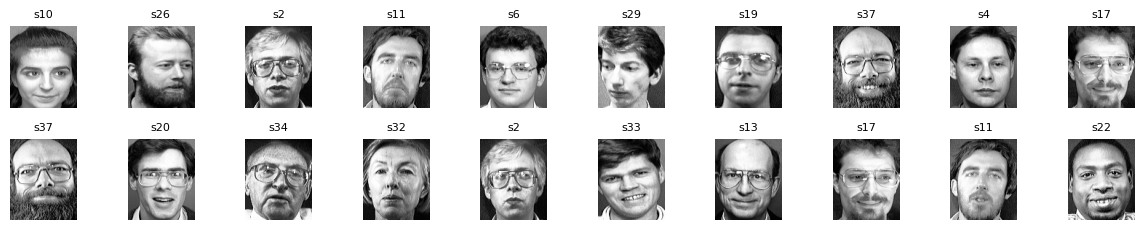

In [ ]:
# CELL 3 — Load dataset (memory-safe), show samples

import cv2

def load_att_faces(root: Path, hist_eq: bool = True):
    images, labels, paths = [], [], []
    subject_dirs = sorted(
        [p for p in root.iterdir() if p.is_dir() and p.name.startswith("s")],
        key=lambda p: int(p.name[1:])
    )
    for s_idx, sdir in enumerate(subject_dirs):
        for f in sorted(list(sdir.glob("*.pgm"))):
            img = cv2.imread(str(f), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            if hist_eq:
                img = cv2.equalizeHist(img)
            images.append(img.astype(np.uint8))
            labels.append(s_idx)
            paths.append(str(f))
    X = np.stack(images, axis=0)
    y = np.array(labels, dtype=np.int64)
    return X, y, paths

X_img, y, img_paths = load_att_faces(DATA_ROOT, hist_eq=APPLY_HIST_EQ)
n_classes = len(np.unique(y))

print("Loaded images:", X_img.shape)
print("Unique subjects:", n_classes)
assert n_classes == 40, "Expected 40 subjects."

show_grid(X_img, y, n=20, cols=10, seed=1)

In [ ]:
# CELL 4 — Identity-stratified split (same split reused for all pipelines)

SPLITS = {}
for s in SEEDS:
    tr, te = split_per_identity(y, seed=s, n_test_per_subject=N_TEST_PER_SUBJECT)
    SPLITS[s] = {"train_idx": tr, "test_idx": te}

print("Train size:", len(SPLITS[42]["train_idx"]), "Test size:", len(SPLITS[42]["test_idx"]))

Train size: 280 Test size: 120


## Pipeline A — PCA (Eigenfaces-style) + Linear SVM

In [ ]:
# CELL 5 — Preprocess for PCA / MLP

from sklearn.preprocessing import FunctionTransformer, StandardScaler

X_flat = X_img.reshape(len(X_img), -1)
to_float01 = FunctionTransformer(lambda Z: (Z.astype(np.float32) / 255.0), feature_names_out="one-to-one")
center_only = StandardScaler(with_std=False)

print("Flattened:", X_flat.shape)

Flattened: (400, 10304)


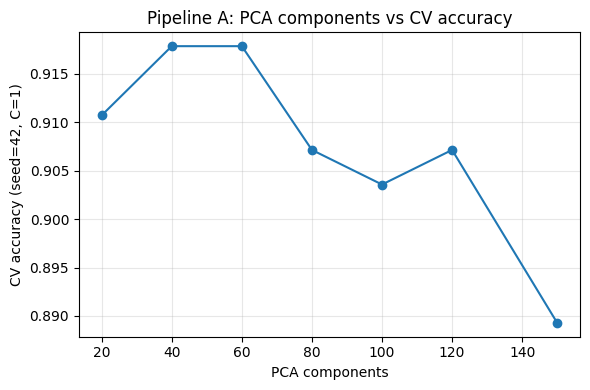

In [ ]:
# CELL 6 — Tune PCA components + SVM + plot curve (seed=42)

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def build_pipeline_a(seed: int):
    return Pipeline([
        ("to_float01", to_float01),
        ("center", center_only),
        ("pca", PCA(whiten=True, svd_solver="randomized", random_state=seed)),
        ("svm", SVC(kernel="linear"))
    ])

def tune_pipeline_a(X, y, train_idx, seed: int):
    Xtr, ytr = X[train_idx], y[train_idx]
    pipe = build_pipeline_a(seed)
    param_grid = {"pca__n_components": PCA_COMPONENTS_GRID, "svm__C": SVM_C_GRID}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=0)
    gs.fit(Xtr, ytr)
    return gs

seed_curve = 42
tr_curve = SPLITS[seed_curve]["train_idx"]
Xtr_curve, ytr_curve = X_flat[tr_curve], y[tr_curve]

curve_scores = []
for k in PCA_COMPONENTS_GRID:
    pipe = build_pipeline_a(seed_curve).set_params(pca__n_components=k, svm__C=1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_curve)
    gs = GridSearchCV(pipe, param_grid={"pca__n_components":[k], "svm__C":[1]}, scoring="accuracy", cv=cv, n_jobs=-1, verbose=0)
    gs.fit(Xtr_curve, ytr_curve)
    curve_scores.append(gs.best_score_)

plt.figure(figsize=(6,4))
plt.plot(PCA_COMPONENTS_GRID, curve_scores, marker="o")
plt.xlabel("PCA components")
plt.ylabel("CV accuracy (seed=42, C=1)")
plt.title("Pipeline A: PCA components vs CV accuracy")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "pca_components_curve_seed42.png", dpi=200)
plt.show()

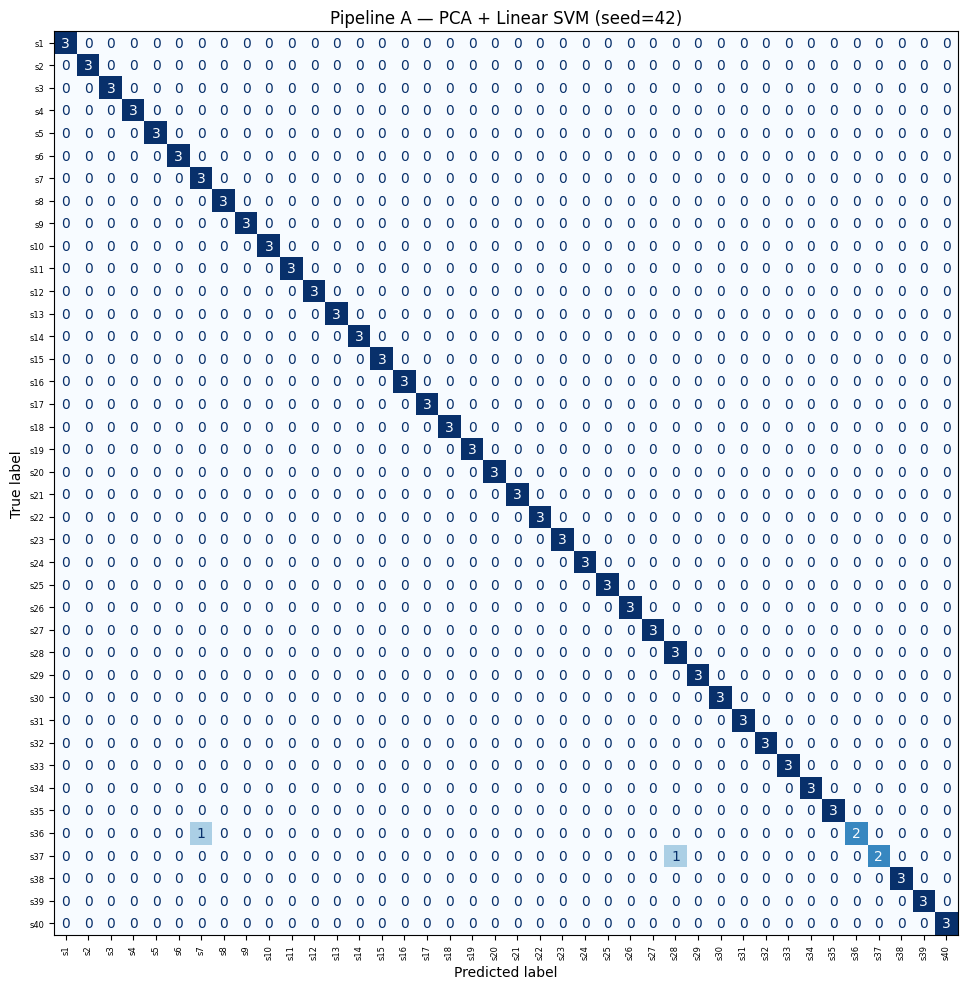

In [ ]:
# CELL 7 — Train + evaluate Pipeline A (all seeds)

PIPE_A_RUNS = []
PIPE_A_CM_SEED42 = None

for seed in SEEDS:
    tr = SPLITS[seed]["train_idx"]
    te = SPLITS[seed]["test_idx"]

    gs = tune_pipeline_a(X_flat, y, tr, seed=seed)
    model = gs.best_estimator_

    Xtr, ytr = X_flat[tr], y[tr]
    Xte, yte = X_flat[te], y[te]

    t0 = time.perf_counter()
    model.fit(Xtr, ytr)
    train_s = time.perf_counter() - t0

    t1 = time.perf_counter()
    yhat = model.predict(Xte)
    infer_s = time.perf_counter() - t1

    acc, p, r, f1 = eval_metrics(yte, yhat)

    PIPE_A_RUNS.append({
        "pipeline": "A_PCA+LinearSVM",
        "seed": seed,
        "best_params": gs.best_params_,
        "acc": float(acc),
        "macro_precision": float(p),
        "macro_recall": float(r),
        "macro_f1": float(f1),
        "train_s": float(train_s),
        "infer_ms_per_img": float((infer_s / len(Xte)) * 1000.0),
    })

    if seed == 42:
        PIPE_A_CM_SEED42 = save_confusion(
            y_true=yte, y_pred=yhat,
            title="Pipeline A — PCA + Linear SVM (seed=42)",
            outpath=RESULTS_DIR / "cm_pipelineA_seed42.png",
            n_classes=n_classes
        )

## Pipeline B — Transfer Learning Embeddings (ResNet18) + Linear SVM

In [ ]:
# CELL 8 — Load pretrained embedding model (ResNet18 feature extractor)

import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.DEFAULT

base = resnet18(weights=weights)
embedder = nn.Sequential(*list(base.children())[:-1]).eval().to(device)
preprocess = weights.transforms()

def gray_to_rgb_pil(gray_uint8: np.ndarray) -> Image.Image:
    return Image.fromarray(gray_uint8).convert("RGB")

print("✅ ResNet18 loaded on:", device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


✅ ResNet18 loaded on: cpu


In [ ]:
# CELL 9 — Compute embeddings

def compute_resnet_embeddings(X_gray_uint8: np.ndarray, batch_size: int = 64):
    embs = []
    with torch.no_grad():
        for start in range(0, len(X_gray_uint8), batch_size):
            batch = X_gray_uint8[start:start+batch_size]
            batch_t = torch.stack([preprocess(gray_to_rgb_pil(im)) for im in batch], dim=0).to(device)
            feat = embedder(batch_t).view(len(batch), -1)
            feat = torch.nn.functional.normalize(feat, p=2, dim=1)
            embs.append(feat.cpu().numpy().astype(np.float32))
    return np.vstack(embs)

X_emb = compute_resnet_embeddings(X_img, batch_size=EMB_BATCH_SIZE)
print("Embeddings:", X_emb.shape)

Embeddings: (400, 512)


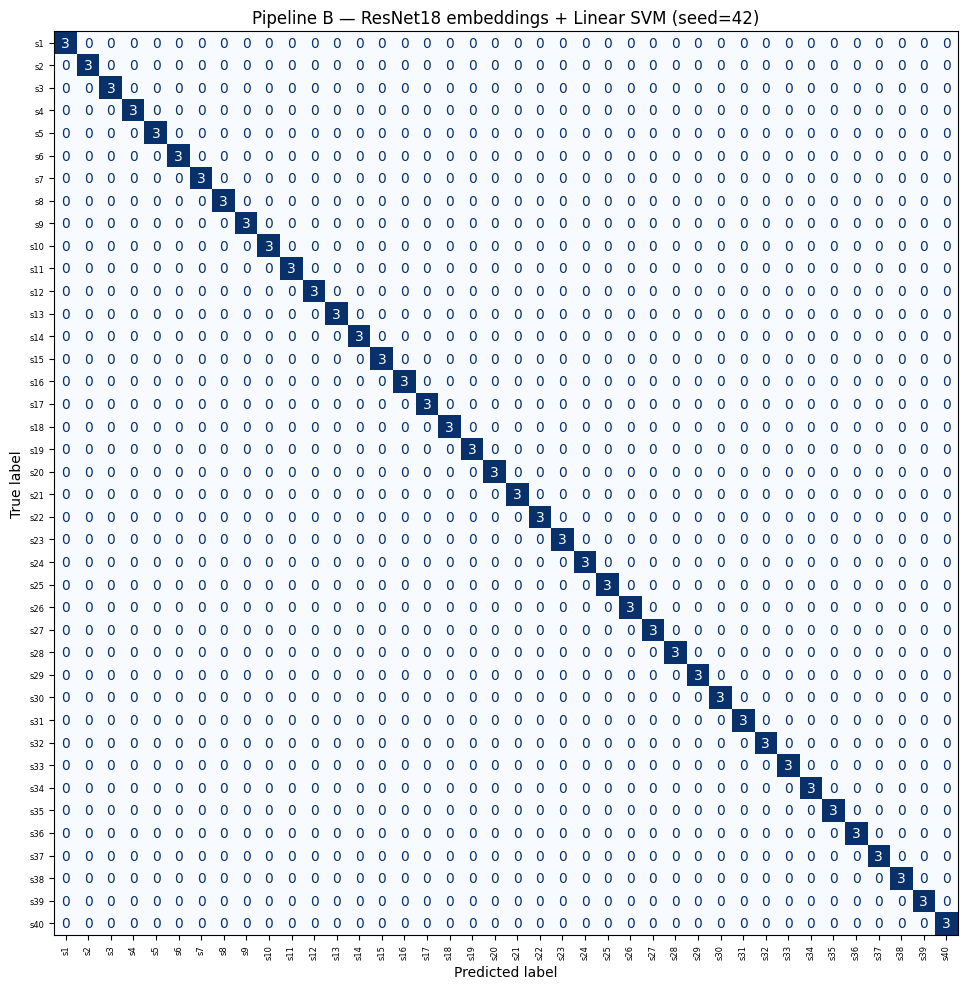

In [ ]:
# CELL 10 — Train + evaluate Pipeline B (all seeds)

def tune_pipeline_b(Xemb, y, train_idx, seed: int):
    Xtr, ytr = Xemb[train_idx], y[train_idx]
    pipe = Pipeline([("scaler", StandardScaler()), ("svm", SVC(kernel="linear"))])
    param_grid = {"svm__C": SVM_C_GRID}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=0)
    gs.fit(Xtr, ytr)
    return gs

PIPE_B_RUNS = []
PIPE_B_CM_SEED42 = None

for seed in SEEDS:
    tr = SPLITS[seed]["train_idx"]
    te = SPLITS[seed]["test_idx"]

    gs = tune_pipeline_b(X_emb, y, tr, seed=seed)
    model = gs.best_estimator_

    Xtr, ytr = X_emb[tr], y[tr]
    Xte, yte = X_emb[te], y[te]

    t0 = time.perf_counter()
    model.fit(Xtr, ytr)
    train_s = time.perf_counter() - t0

    t1 = time.perf_counter()
    yhat = model.predict(Xte)
    infer_s = time.perf_counter() - t1

    acc, p, r, f1 = eval_metrics(yte, yhat)

    PIPE_B_RUNS.append({
        "pipeline": "B_ResNet18Embeddings+LinearSVM",
        "seed": seed,
        "best_params": gs.best_params_,
        "acc": float(acc),
        "macro_precision": float(p),
        "macro_recall": float(r),
        "macro_f1": float(f1),
        "train_s": float(train_s),
        "infer_ms_per_img": float((infer_s / len(Xte)) * 1000.0),
    })

    if seed == 42:
        PIPE_B_CM_SEED42 = save_confusion(
            y_true=yte, y_pred=yhat,
            title="Pipeline B — ResNet18 embeddings + Linear SVM (seed=42)",
            outpath=RESULTS_DIR / "cm_pipelineB_seed42.png",
            n_classes=n_classes
        )

## Pipeline C — MLP (Multi-Layer Perceptron) on Flattened Pixels

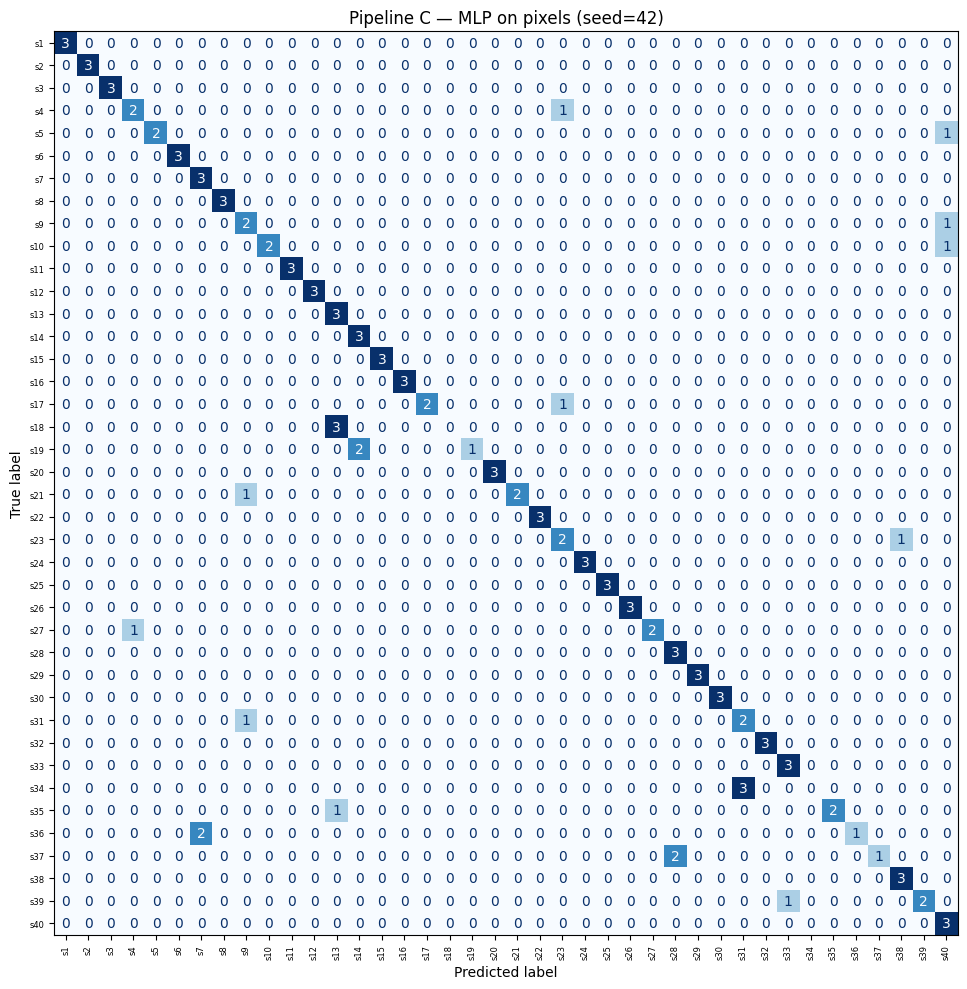

In [ ]:
# CELL 11 — Train + evaluate Pipeline C (MLP) (all seeds)

from sklearn.neural_network import MLPClassifier

def tune_pipeline_c(Xflat, y, train_idx, seed: int):
    Xtr, ytr = Xflat[train_idx], y[train_idx]
    pipe = Pipeline([
        ("to_float01", to_float01),
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            activation="relu",
            solver="adam",
            early_stopping=True,
            max_iter=400,
            random_state=seed
        ))
    ])
    param_grid = {
        "mlp__hidden_layer_sizes": MLP_HIDDEN_GRID,
        "mlp__alpha": MLP_ALPHA_GRID
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=0)
    gs.fit(Xtr, ytr)
    return gs

PIPE_C_RUNS = []
PIPE_C_CM_SEED42 = None

for seed in SEEDS:
    tr = SPLITS[seed]["train_idx"]
    te = SPLITS[seed]["test_idx"]

    gs = tune_pipeline_c(X_flat, y, tr, seed=seed)
    model = gs.best_estimator_

    Xtr, ytr = X_flat[tr], y[tr]
    Xte, yte = X_flat[te], y[te]

    t0 = time.perf_counter()
    model.fit(Xtr, ytr)
    train_s = time.perf_counter() - t0

    t1 = time.perf_counter()
    yhat = model.predict(Xte)
    infer_s = time.perf_counter() - t1

    acc, p, r, f1 = eval_metrics(yte, yhat)

    PIPE_C_RUNS.append({
        "pipeline": "C_MLP(FlattenedPixels)",
        "seed": seed,
        "best_params": gs.best_params_,
        "acc": float(acc),
        "macro_precision": float(p),
        "macro_recall": float(r),
        "macro_f1": float(f1),
        "train_s": float(train_s),
        "infer_ms_per_img": float((infer_s / len(Xte)) * 1000.0),
    })

    if seed == 42:
        PIPE_C_CM_SEED42 = save_confusion(
            y_true=yte, y_pred=yhat,
            title="Pipeline C — MLP on pixels (seed=42)",
            outpath=RESULTS_DIR / "cm_pipelineC_seed42.png",
            n_classes=n_classes
        )

## Comparison — tables + graphs + export

In [ ]:
# CELL 12 — Comparison tables + CSV export

import pandas as pd

df = pd.concat([pd.DataFrame(PIPE_A_RUNS), pd.DataFrame(PIPE_B_RUNS), pd.DataFrame(PIPE_C_RUNS)], ignore_index=True)
display(df[["pipeline","seed","acc","macro_f1","train_s","infer_ms_per_img","best_params"]])

summary = df.groupby("pipeline").agg(
    acc_mean=("acc","mean"),
    acc_std=("acc","std"),
    f1_mean=("macro_f1","mean"),
    f1_std=("macro_f1","std"),
    train_s_mean=("train_s","mean"),
    infer_ms_mean=("infer_ms_per_img","mean"),
).reset_index()

display(summary)

df.to_csv(RESULTS_DIR / "runs_all_seeds.csv", index=False)
summary.to_csv(RESULTS_DIR / "summary_mean_std.csv", index=False)
print("Saved CSVs to:", RESULTS_DIR)

,pipeline,seed,acc,macro_f1,train_s,infer_ms_per_img,best_params
0,A_PCA+LinearSVM,42,0.983333,0.982857,0.473114,0.151733,"{'pca__n_components': 40, 'svm__C': 0.1}"
1,A_PCA+LinearSVM,123,0.925000,0.918571,0.553496,0.150616,"{'pca__n_components': 40, 'svm__C': 0.1}"
2,A_PCA+LinearSVM,256,0.983333,0.982857,0.361598,0.169409,"{'pca__n_components': 40, 'svm__C': 0.1}"
3,A_PCA+LinearSVM,789,0.975000,0.974286,0.545792,0.223988,"{'pca__n_components': 60, 'svm__C': 0.1}"
4,A_PCA+LinearSVM,1024,0.950000,0.948810,0.347911,0.149303,"{'pca__n_components': 40, 'svm__C': 0.1}"
5,B_ResNet18Embeddings+LinearSVM,42,1.000000,1.000000,0.031370,0.063568,{'svm__C': 0.1}
6,B_ResNet18Embeddings+LinearSVM,123,1.000000,1.000000,0.060235,0.105313,{'svm__C': 0.1}
7,B_ResNet18Embeddings+LinearSVM,256,0.983333,0.982857,0.044550,0.102263,{'svm__C': 0.1}
8,B_ResNet18Embeddings+LinearSVM,789,0.975000,0.972679,0.027916,0.065826,{'svm__C': 0.1}
9,B_ResNet18Embeddings+LinearSVM,1024,0.966667,0.963214,0.031554,0.068200,{'svm__C': 0.1}


,pipeline,acc_mean,acc_std,f1_mean,f1_std,train_s_mean,infer_ms_mean
0,A_PCA+LinearSVM,0.963333,0.025413,0.961476,0.027747,0.456382,0.169010
1,B_ResNet18Embeddings+LinearSVM,0.985000,0.014907,0.983750,0.016380,0.039125,0.081034
2,C_MLP(FlattenedPixels),0.815000,0.051841,0.798726,0.059899,4.751887,0.336267


Saved CSVs to: /content/results


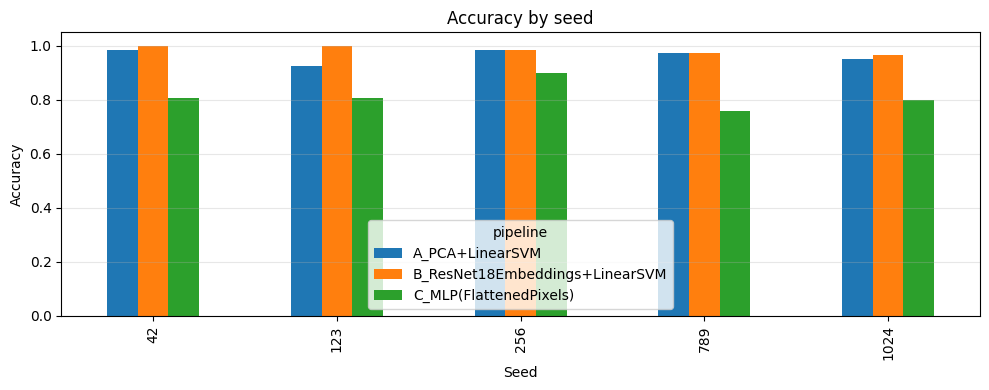

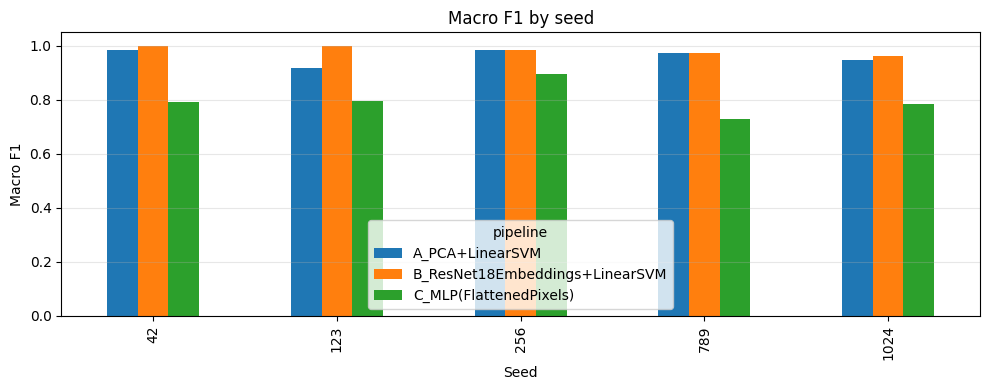

<Figure size 900x400 with 0 Axes>

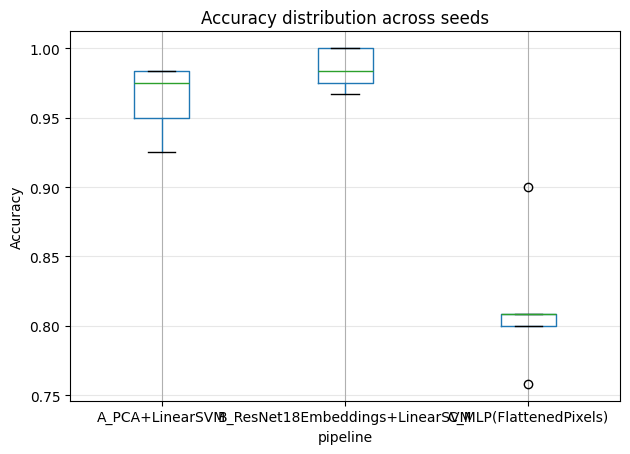

<Figure size 900x400 with 0 Axes>

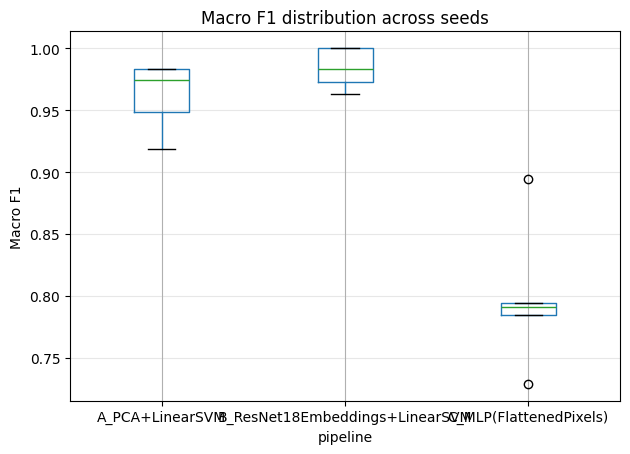

In [ ]:
# CELL 13 — Comparison plots

seed_order = SEEDS

def plot_seed_bars(metric, title, ylabel, outname):
    pivot = df.pivot(index="seed", columns="pipeline", values=metric).loc[seed_order]
    ax = pivot.plot(kind="bar", figsize=(10,4))
    ax.set_title(title)
    ax.set_xlabel("Seed")
    ax.set_ylabel(ylabel)
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / outname, dpi=200)
    plt.show()

plot_seed_bars("acc", "Accuracy by seed", "Accuracy", "acc_by_seed.png")
plot_seed_bars("macro_f1", "Macro F1 by seed", "Macro F1", "f1_by_seed.png")

plt.figure(figsize=(9,4))
df.boxplot(column="acc", by="pipeline")
plt.title("Accuracy distribution across seeds")
plt.suptitle("")
plt.ylabel("Accuracy")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "acc_boxplot.png", dpi=200)
plt.show()

plt.figure(figsize=(9,4))
df.boxplot(column="macro_f1", by="pipeline")
plt.title("Macro F1 distribution across seeds")
plt.suptitle("")
plt.ylabel("Macro F1")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "f1_boxplot.png", dpi=200)
plt.show()

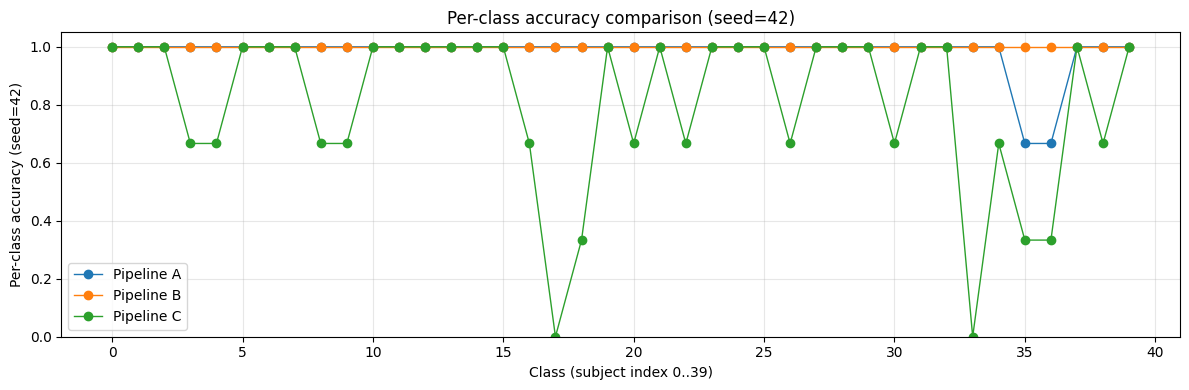

In [ ]:
# CELL 14 — Per-class accuracy plot (seed=42) for A vs B vs C

accA = per_class_accuracy(PIPE_A_CM_SEED42)
accB = per_class_accuracy(PIPE_B_CM_SEED42)
accC = per_class_accuracy(PIPE_C_CM_SEED42)

x = np.arange(len(accA))
plt.figure(figsize=(12,4))
plt.plot(x, accA, marker="o", linewidth=1, label="Pipeline A")
plt.plot(x, accB, marker="o", linewidth=1, label="Pipeline B")
plt.plot(x, accC, marker="o", linewidth=1, label="Pipeline C")
plt.ylim(0, 1.05)
plt.xlabel("Class (subject index 0..39)")
plt.ylabel("Per-class accuracy (seed=42)")
plt.title("Per-class accuracy comparison (seed=42)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "per_class_accuracy_seed42.png", dpi=200)
plt.show()

In [ ]:
# CELL 15 — Winner decision

best = summary.sort_values(["f1_mean","acc_mean"], ascending=False).iloc[0]
print("🏆 Winner:", best["pipeline"])
print(best)

🏆 Winner: B_ResNet18Embeddings+LinearSVM
pipeline         B_ResNet18Embeddings+LinearSVM
acc_mean                                  0.985
acc_std                                0.014907
f1_mean                                 0.98375
f1_std                                  0.01638
train_s_mean                           0.039125
infer_ms_mean                          0.081034
Name: 1, dtype: object


In [ ]:
# CELL 16 — Zip results + download

zip_path = Path("/content/results.zip")
if zip_path.exists():
    zip_path.unlink()

shutil.make_archive("/content/results", "zip", RESULTS_DIR)
print("Created:", zip_path)

from google.colab import files
files.download(str(zip_path))

Created: /content/results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>